In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import tensorflow as tf
import os
from typing import Tuple
# opencv for image processing
import cv2
import tqdm
from sklearn.model_selection import train_test_split



In [63]:
train_images= np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
val_images= np.load('val_images.npy')
val_labels = np.load('val_labels.npy')


In [64]:

# Merge images
merged_images = np.concatenate((train_images, val_images), axis=0)
# Merge labels
merged_labels = np.concatenate((train_labels, val_labels), axis=0)

# Split the merged dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    merged_images, merged_labels, test_size=0.15, random_state=42, stratify=merged_labels
)
# Add the channel dimension to the images, that is 1 because we have grays scale images
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)


1


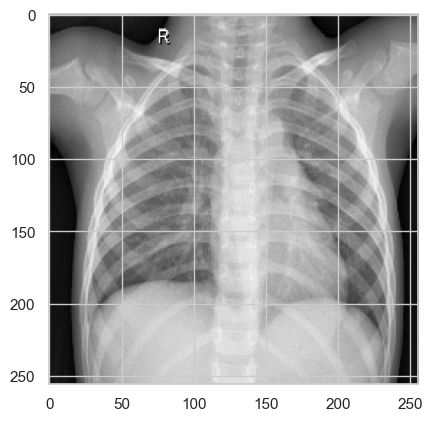

In [71]:
# Get all the pixel values in the range of 0 to 1
# train_images = train_images / 255.0
# display the image
plt.imshow(train_images[2],
            cmap='gray')
print(train_labels[2])

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)

# Preprocess data (get all values between 0 and 1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# turn the data into batches
train_data = train_datagen.flow(train_images,
                                batch_size=32,                             
                                shuffle=True,
                                seed = 42)
valid_data = valid_datagen.flow(val_images,
                                batch_size=32,
                               
                                shuffle=False,
                                seed = 42)
# Build a CNN model (same as Tiny VGG on the CNN explainer website)

model_1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(256,256,1)),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2,padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [52]:
# Assuming train_images is your input data and train_labels is your target labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))

# Similarly for validation data
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [50]:
# fit the model
history_1 = model_1.fit(train_data,train_labels,
                         epochs=1,
                         steps_per_epoch=len(train_data),
                         validation_data=(valid_data,val_labels),
                         validation_steps=len(valid_data))


ValueError: When providing `x` as a PyDataset, `y` should not be passed. Instead, the targets should be included as part of the PyDataset.